# Sobre o Dataset:


Fonte: https://www.kaggle.com/datasets/cerranet/cerradata-version3

**Conjunto de Dados do Bioma Cerrado (CerraData)**

A versão 3 do CerraData foi desenvolvida para incentivar o desenvolvimento de métodos e modelos de classificação de imagens, em especial técnicas de aprendizado profundo (deep learning), voltadas para os tipos de uso e cobertura da terra no bioma Cerrado.

Nesta versão, foram definidas 80.000 amostras rotuladas em oito classes de uso e cobertura da terra, com o apoio de especialistas:

i) Edificação: áreas urbanas e rurais edificadas;

ii) Área Cultivada: agricultura com um, dois ou mais ciclos, culturas perenes e semiperenes;

iii) Floresta: formações arbóreas e matas ciliares, de galeria, secas e plantadas;

iv) Área Não Observada: nuvens, sombras de nuvens, incêndios e cicatrizes de queimadas;

v) Outros Usos: mineração, afloramentos rochosos, praias e dunas;

vi) Pasto: formações campestres e vegetação herbácea forrageira de espécies cultivadas;

vii) Formação Savânica: savana arborizada, savana típica, savana rupestre, savana arbustiva e vereda;

viii) Água: rios, pequenos lagos, barragens e viveiros de piscicultura.


Os recortes foram selecionados, anotados e validados manualmente por especialistas em uso e cobertura da terra (LULC), seguindo a metodologia do PRODES. Essa tarefa é demorada e exige muita atenção. Cada arquivo é nomeado com data, posição geográfica e um identificador que se refere à sequência do recorte.
Foram necessários três meses para concluir todas as etapas mencionadas: os dois primeiros para fusão, pan-sharpening, recorte e remoção de valores sem dados nas imagens; e o último para a rotulagem, que exigiu um mês inteiro.


# Carregando os dados do Dataset

In [1]:
!pip install -q kagglehub

In [2]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 31.3 MB/s eta 0:00:00


In [22]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import os
from google.colab import files
import kagglehub
import rasterio
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

Para executar o notebook em sua máquina, é necessário ter uma conta no Kaggle, baixar o json da sua API e inserir no campo abaixo

In [4]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"felipelemess1988","key":"8286ab7e40c5e651f91ddb6fad61e3e5"}'}

In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
# Baixar a versão mais recente
path = kagglehub.dataset_download("cerranet/cerradata-version3")

print("Path to dataset files:", path)

100%|██████████| 13.2G/13.2G [02:38<00:00, 89.8MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/cerranet/cerradata-version3/versions/1


In [7]:
base_path = "/root/.cache/kagglehub/datasets/cerranet/cerradata-version3/versions/1/cerradatav3"

# Listar as classes (pastas principais)
classes = sorted([
    cls for cls in os.listdir(base_path)
    if os.path.isdir(os.path.join(base_path, cls))
])

# Contar todos os .tif dentro de cada classe (recursivamente)
for cls in classes:
    cls_path = os.path.join(base_path, cls)
    n_files = 0
    for root, _, files in os.walk(cls_path):
        n_files += len([f for f in files if f.endswith('.tif')])
    print(f"{cls}: {n_files} imagens")

building: 10000 imagens
cultivated_area: 10000 imagens
forest: 10000 imagens
non_observed: 10000 imagens
other_uses: 10000 imagens
pasture: 10000 imagens
savanna_formation: 10000 imagens
water: 10000 imagens


In [8]:
# Tenta encontrar a primeira classe com imagens .tif
for cls in classes:
    print(f"Verificando classe: {cls}")
    cls_path = os.path.join(base_path, cls)
    tif_files = []
    for root, _, files in os.walk(cls_path):
        for file in files:
            if file.endswith(".tif"):
                tif_files.append(os.path.join(root, file))
        if tif_files:
            break
    if tif_files:
        print(f"{cls}: {len(tif_files)} arquivos encontrados")
        print("Exemplo de caminho:", tif_files[0])
        break

Verificando classe: building
building: 10000 arquivos encontrados
Exemplo de caminho: /root/.cache/kagglehub/datasets/cerranet/cerradata-version3/versions/1/cerradatav3/building/20210816_207_134_L4_5550.tif


Como neste projeto não irei usar convolução, é preciso transformar cada imagem .tif em um vetor de atributos numéricos, por exemplo: Média por banda espectral,Desvio padrão por banda, NDVI, se houver banda NIR e Red, Mínimo/máximo dos valores de pixel.

# Carregando uma imagem .tiff e visualizando suas bandas

Shape da imagem (bandas, altura, largura): (4, 257, 256)


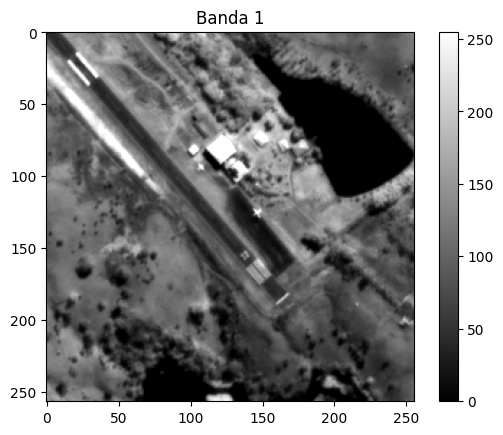

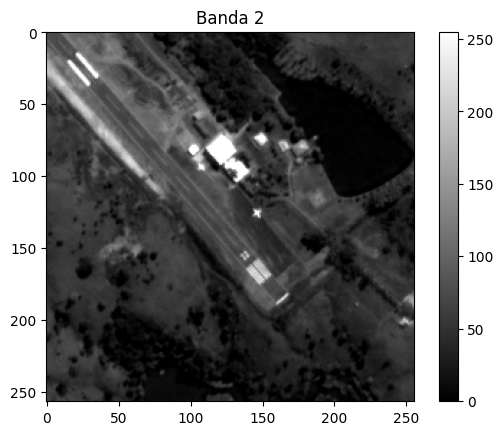

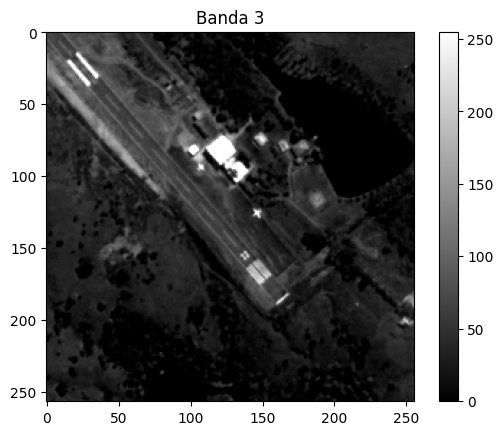

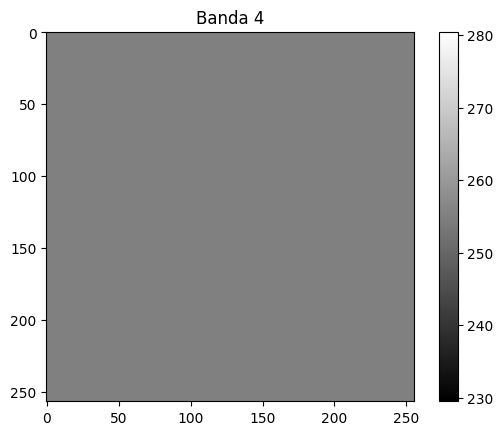

In [9]:
tif_path = "/root/.cache/kagglehub/datasets/cerranet/cerradata-version3/versions/1/cerradatav3/building/20210711_208_134_L4_15666.tif"

with rasterio.open(tif_path) as src:
    img = src.read()  # formato: (bandas, altura, largura)
    print("Shape da imagem (bandas, altura, largura):", img.shape)

    # Visualizar até 4 bandas (se houver)
    for i in range(min(4, img.shape[0])):
        plt.imshow(img[i], cmap="gray")
        plt.title(f"Banda {i+1}")
        plt.colorbar()
        plt.show()

**Shape da imagem (bandas, altura, largura): (4, 257, 256)**

**Banda 1:** Azul (Blue)  Realce da água, atmosfera

**Banda 2:**Verde (Green) Vegetação saudável reflete bastante nessa faixa

**Banda 3:**Vermelha (Red) Essencial para NDVI e diferenciação de vegetação

**Banda 4:** Infravermelho Altamente refletido por vegetação saudável (NIR)


In [10]:
# Função para extrair features de uma imagem
def extrair_features(img_array):
    features = {}
    for i in range(img_array.shape[0]):
        banda = img_array[i]
        features[f"banda_{i+1}_mean"] = np.mean(banda)
        features[f"banda_{i+1}_std"] = np.std(banda)
        features[f"banda_{i+1}_min"] = np.min(banda)
        features[f"banda_{i+1}_max"] = np.max(banda)
    return features

# Aplica a função na imagem carregada
features = extrair_features(img)
df = pd.DataFrame([features])
print(df.T)  # transposto para facilitar visualização

                       0
banda_1_mean   88.291130
banda_1_std    52.577298
banda_1_min     0.000000
banda_1_max   255.000000
banda_2_mean   50.455998
banda_2_std    39.991784
banda_2_min     0.000000
banda_2_max   255.000000
banda_3_mean   34.201559
banda_3_std    36.830084
banda_3_min     0.000000
banda_3_max   255.000000
banda_4_mean  255.000000
banda_4_std     0.000000
banda_4_min   255.000000
banda_4_max   255.000000


A Banda 4 está totalmente saturada, isso invalida o uso dela como NIR para cálculo de NDVI neste caso específico.

**Porém, ainda é possivel usar as bandas 1,2 e 3 (Blue, Green, Red) e seus resumos estatísticos. Para o restante do dataset, quando for encontrada bandas válidas, calcularemos o NDVI apenas quando possível**


# Extraindo features de várias imagens com rótulo da classe

In [11]:
# Lista das classes
classes = sorted([
    cls for cls in os.listdir(base_path)
    if os.path.isdir(os.path.join(base_path, cls))
])

# Função para extrair estatísticas das bandas
def extrair_features(img_array):
    features = {}
    for i in range(img_array.shape[0]):
        banda = img_array[i]
        features[f"banda_{i+1}_mean"] = np.mean(banda)
        features[f"banda_{i+1}_std"] = np.std(banda)
        features[f"banda_{i+1}_min"] = np.min(banda)
        features[f"banda_{i+1}_max"] = np.max(banda)
    return features

# Limite de imagens por classe
limite_por_classe = 2000

# Lista para armazenar os dados
registros = []

# Loop principal
for cls in tqdm(classes):
    cls_path = os.path.join(base_path, cls)
    count = 0

    for root, _, files in os.walk(cls_path):
        for file in files:
            if file.endswith(".tif"):
                try:
                    caminho_completo = os.path.join(root, file)
                    with rasterio.open(caminho_completo) as src:
                        img = src.read()
                        if img.shape[0] >= 3:
                            feats = extrair_features(img)

                            # Classe correta: pasta após 'cerradatav3/'
                            classe = caminho_completo.split("cerradatav3" + os.sep)[1].split(os.sep)[0]
                            feats['classe'] = classe

                            registros.append(feats)
                            count += 1
                except:
                    continue

            if count >= limite_por_classe:
                break

    if count == 0:
        print(f"Nenhuma imagem válida encontrada na classe {cls}")

# Criar DataFrame final
df = pd.DataFrame(registros)
print("Shape do DataFrame:", df.shape)
print(df['classe'].value_counts())
df.head()

  0%|          | 0/8 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Shape do DataFrame: (16000, 17)
classe
building             2000
cultivated_area      2000
forest               2000
non_observed         2000
other_uses           2000
pasture              2000
savanna_formation    2000
water                2000
Name: count, dtype: int64


,banda_1_mean,banda_1_std,banda_1_min,banda_1_max,banda_2_mean,banda_2_std,banda_2_min,banda_2_max,banda_3_mean,banda_3_std,banda_3_min,banda_3_max,banda_4_mean,banda_4_std,banda_4_min,banda_4_max,classe
0,113.079554,50.216216,0,255,92.689142,58.588355,0,255,89.102885,54.317084,0,255,254.996124,0.994146,0,255,building
1,96.072754,52.028429,0,244,86.263763,47.856133,0,255,92.377640,47.528483,0,255,255.000000,0.000000,255,255,building
2,103.621565,38.575704,2,255,76.429870,38.614933,0,255,76.067759,37.200582,0,255,255.000000,0.000000,255,255,building
3,86.889607,34.633662,0,255,40.873039,25.334115,0,255,25.877022,22.482383,0,255,255.000000,0.000000,255,255,building
4,116.472634,34.984054,0,255,96.372648,43.817158,0,255,89.321292,41.181078,0,255,254.996139,0.992210,0,255,building


# Codificando as classes com LabelEncoder

In [28]:
# Cria um codificador
le = LabelEncoder()

# Aplica a codificação nas classes
df['classe_codificada'] = le.fit_transform(df['classe'])

# Mostra o mapeamento: classe original → número
classe_map = dict(zip(le.classes_, le.transform(le.classes_)))
print("Mapeamento de classes:", classe_map)

# Visualiza as primeiras linhas com a nova coluna
df[['classe', 'classe_codificada']].head()

Mapeamento de classes: {'building': np.int64(0), 'cultivated_area': np.int64(1), 'forest': np.int64(2), 'non_observed': np.int64(3), 'other_uses': np.int64(4), 'pasture': np.int64(5), 'savanna_formation': np.int64(6), 'water': np.int64(7)}


,classe,classe_codificada
0,building,0
1,building,0
2,building,0
3,building,0
4,building,0


# Preparando tensores e definindo o modelo

# Treinando a rede


CLASSE DA REDE NEURAL (MLP COM DROPOUT):

In [29]:
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, output_dim)
        )

    def forward(self, x):
        return self.model(x)

PREPARAR OS DADOS (X, y)

In [30]:
X = df.drop(columns=['classe', 'classe_codificada']).values
y = df['classe_codificada'].values
input_dim = X.shape[1]
output_dim = len(np.unique(y))

CROSS-VALIDATION COM VISUALIZAÇÃO DE PERDA

In [26]:
#batch size = 32 é um valor padrao muito usado pois é pequeno o suficiente para manter o treinamento rápido e leve no Colab, ajuda o gradiente a ter um pouco de variaç
# e é potência de 2 (ajuda em otimização de memória/GPU).
classe_nomes = np.unique(df['classe'].values)

def treinar_com_cross_validation(X, y, input_dim, output_dim, classe_nomes, num_epochs=100, batch_size=32, lr=0.001):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    accuracies = []
    all_losses = []
    all_conf_matrices = []

    for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
        print(f"\nFold {fold+1}/5")

        # Separar e normalizar
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Tensores
        X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train, dtype=torch.long)
        X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
        y_test_tensor = torch.tensor(y_test, dtype=torch.long)

        # Dataloader
        train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

        # Modelo e otimizador
        model = MLP(input_dim, output_dim)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)

        # Treinamento
        losses = []
        for epoch in range(num_epochs):
            model.train()
            total_loss = 0
            for batch_X, batch_y in train_loader:
                optimizer.zero_grad()
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
            avg_loss = total_loss / len(train_loader)
            losses.append(avg_loss)
            if (epoch+1) % 10 == 0 or epoch == 0:
                print(f"Epoch {epoch+1}/{num_epochs} - Loss: {avg_loss:.4f}")

        all_losses.append(losses)

        # Avaliação
        model.eval()
        with torch.no_grad():
            outputs = model(X_test_tensor)
            preds = torch.argmax(outputs, dim=1)

        acc = accuracy_score(y_test, preds)
        accuracies.append(acc)
        print(f"Acurácia no Fold {fold+1}: {acc:.4f}")

        # Relatório e Matriz de Confusão
        print("\nRelatório de Classificação:")
        print(classification_report(y_test, preds, target_names=classe_nomes))
        print("Matriz de Confusão:")

        cm = confusion_matrix(y_test, preds)
        all_conf_matrices.append(cm)

        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classe_nomes)
        disp.plot(cmap="Blues", xticks_rotation=45)
        plt.title(f"Matriz de Confusão - Fold {fold+1}")
        plt.show()

    print(f"\nAcurácia média nos 5 folds: {np.mean(accuracies):.4f}")

    # Visualizar curvas de perda
    plt.figure(figsize=(10, 5))
    for i, losses in enumerate(all_losses):
        plt.plot(losses, label=f"Fold {i+1}")
    plt.title("Curva de perda por época em cada fold")
    plt.xlabel("Época")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

EXECUTAR A FUNÇÃO


Fold 1/5
Epoch 1/100 - Loss: 1.2575
Epoch 10/100 - Loss: 0.7282
Epoch 20/100 - Loss: 0.6656
Epoch 30/100 - Loss: 0.6398
Epoch 40/100 - Loss: 0.6170
Epoch 50/100 - Loss: 0.6083
Epoch 60/100 - Loss: 0.5934
Epoch 70/100 - Loss: 0.5758
Epoch 80/100 - Loss: 0.5700
Epoch 90/100 - Loss: 0.5716
Epoch 100/100 - Loss: 0.5636
Acurácia no Fold 1: 0.8037

Relatório de Classificação:
                   precision    recall  f1-score   support

         building       0.79      0.93      0.86       372
  cultivated_area       0.82      0.78      0.80       395
           forest       0.96      0.97      0.96       416
     non_observed       0.86      0.76      0.81       421
       other_uses       0.79      0.75      0.77       459
          pasture       0.78      0.69      0.73       400
savanna_formation       0.77      0.85      0.81       369
            water       0.65      0.71      0.68       368

         accuracy                           0.80      3200
        macro avg       0.80      

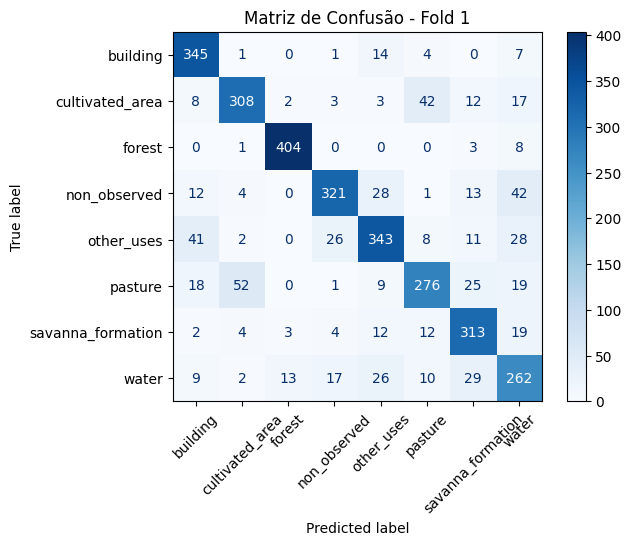


Fold 2/5
Epoch 1/100 - Loss: 1.2518
Epoch 10/100 - Loss: 0.7277
Epoch 20/100 - Loss: 0.6661
Epoch 30/100 - Loss: 0.6350
Epoch 40/100 - Loss: 0.6093
Epoch 50/100 - Loss: 0.6008
Epoch 60/100 - Loss: 0.5872
Epoch 70/100 - Loss: 0.5708
Epoch 80/100 - Loss: 0.5709
Epoch 90/100 - Loss: 0.5646
Epoch 100/100 - Loss: 0.5604
Acurácia no Fold 2: 0.8059

Relatório de Classificação:
                   precision    recall  f1-score   support

         building       0.85      0.93      0.89       397
  cultivated_area       0.84      0.78      0.81       422
           forest       0.95      0.97      0.96       409
     non_observed       0.79      0.71      0.74       360
       other_uses       0.75      0.78      0.77       394
          pasture       0.72      0.77      0.75       388
savanna_formation       0.83      0.83      0.83       425
            water       0.70      0.66      0.68       405

         accuracy                           0.81      3200
        macro avg       0.80      

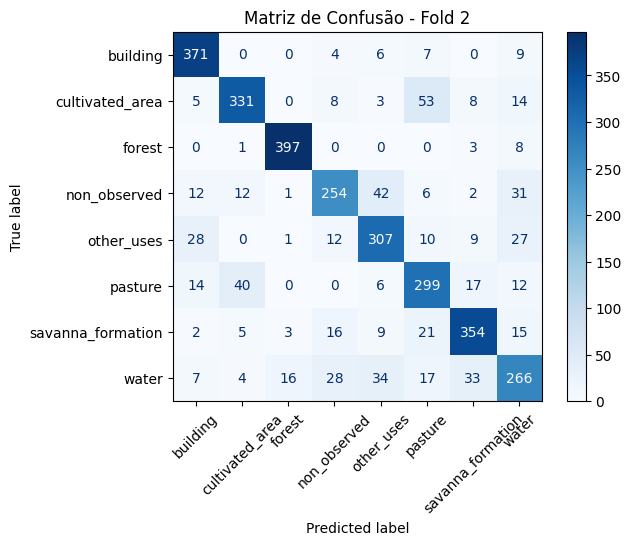


Fold 3/5
Epoch 1/100 - Loss: 1.2824
Epoch 10/100 - Loss: 0.7270
Epoch 20/100 - Loss: 0.6677
Epoch 30/100 - Loss: 0.6395
Epoch 40/100 - Loss: 0.6167
Epoch 50/100 - Loss: 0.6086
Epoch 60/100 - Loss: 0.5910
Epoch 70/100 - Loss: 0.5757
Epoch 80/100 - Loss: 0.5717
Epoch 90/100 - Loss: 0.5643
Epoch 100/100 - Loss: 0.5609
Acurácia no Fold 3: 0.7987

Relatório de Classificação:
                   precision    recall  f1-score   support

         building       0.83      0.94      0.88       426
  cultivated_area       0.85      0.78      0.81       388
           forest       0.97      0.95      0.96       406
     non_observed       0.83      0.71      0.77       395
       other_uses       0.76      0.75      0.75       401
          pasture       0.71      0.77      0.74       371
savanna_formation       0.77      0.85      0.81       383
            water       0.68      0.64      0.66       430

         accuracy                           0.80      3200
        macro avg       0.80      

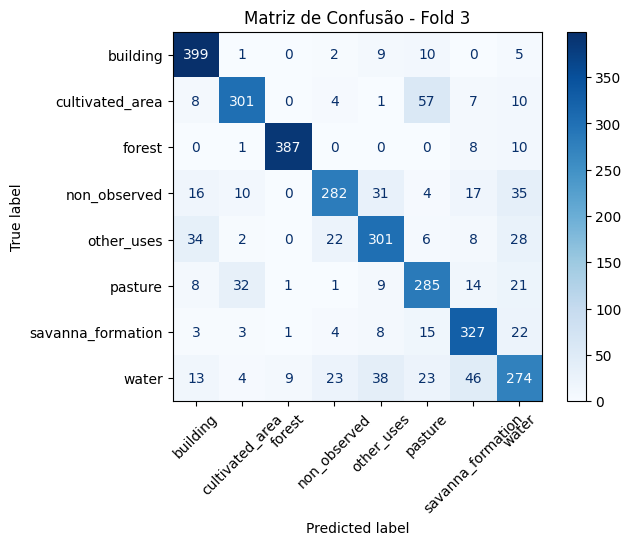


Fold 4/5
Epoch 1/100 - Loss: 1.2723
Epoch 10/100 - Loss: 0.7303
Epoch 20/100 - Loss: 0.6728
Epoch 30/100 - Loss: 0.6493
Epoch 40/100 - Loss: 0.6242
Epoch 50/100 - Loss: 0.6058
Epoch 60/100 - Loss: 0.5984
Epoch 70/100 - Loss: 0.5904
Epoch 80/100 - Loss: 0.5783
Epoch 90/100 - Loss: 0.5643
Epoch 100/100 - Loss: 0.5617
Acurácia no Fold 4: 0.8050

Relatório de Classificação:
                   precision    recall  f1-score   support

         building       0.83      0.93      0.87       411
  cultivated_area       0.86      0.72      0.79       414
           forest       0.96      0.96      0.96       374
     non_observed       0.84      0.75      0.80       404
       other_uses       0.77      0.77      0.77       359
          pasture       0.71      0.80      0.76       421
savanna_formation       0.79      0.84      0.81       401
            water       0.70      0.68      0.69       416

         accuracy                           0.81      3200
        macro avg       0.81      

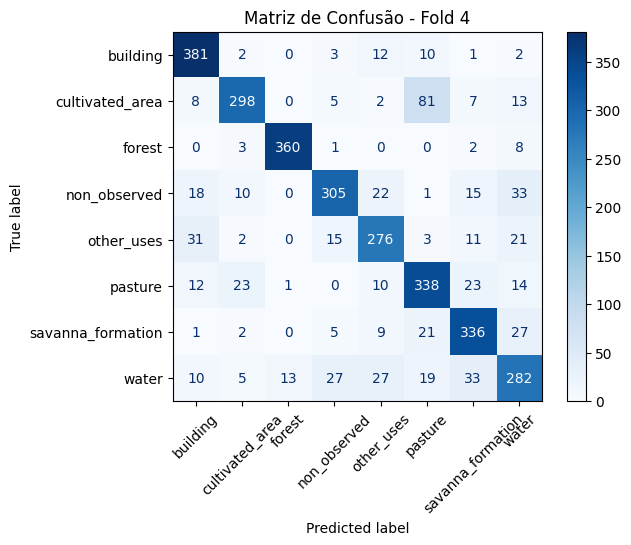


Fold 5/5
Epoch 1/100 - Loss: 1.2686
Epoch 10/100 - Loss: 0.7320
Epoch 20/100 - Loss: 0.6809
Epoch 30/100 - Loss: 0.6333
Epoch 40/100 - Loss: 0.6215
Epoch 50/100 - Loss: 0.6077
Epoch 60/100 - Loss: 0.5932
Epoch 70/100 - Loss: 0.5795
Epoch 80/100 - Loss: 0.5716
Epoch 90/100 - Loss: 0.5585
Epoch 100/100 - Loss: 0.5614
Acurácia no Fold 5: 0.7972

Relatório de Classificação:
                   precision    recall  f1-score   support

         building       0.80      0.93      0.86       394
  cultivated_area       0.82      0.75      0.78       381
           forest       0.97      0.98      0.97       395
     non_observed       0.84      0.73      0.78       420
       other_uses       0.73      0.76      0.74       387
          pasture       0.73      0.74      0.73       420
savanna_formation       0.84      0.81      0.83       422
            water       0.66      0.69      0.68       381

         accuracy                           0.80      3200
        macro avg       0.80      

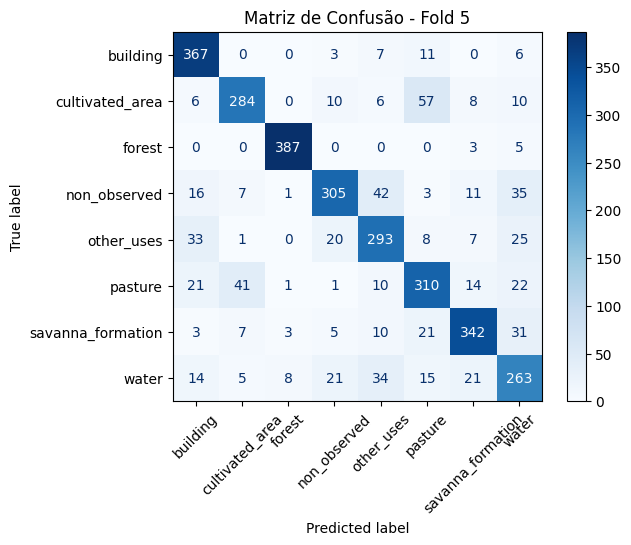


Acurácia média nos 5 folds: 0.8021


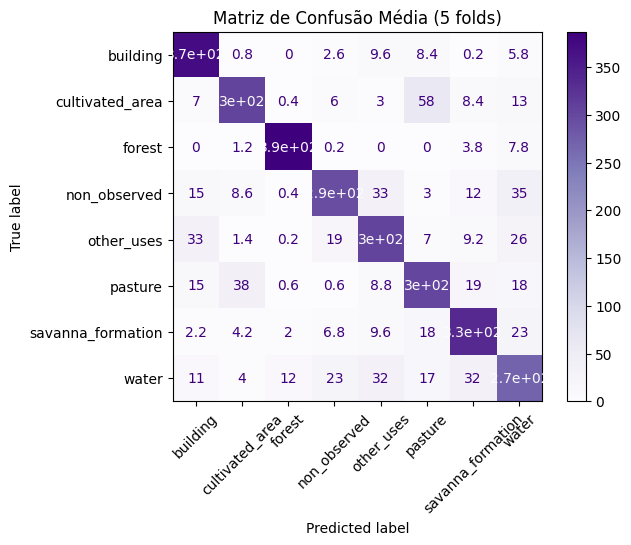

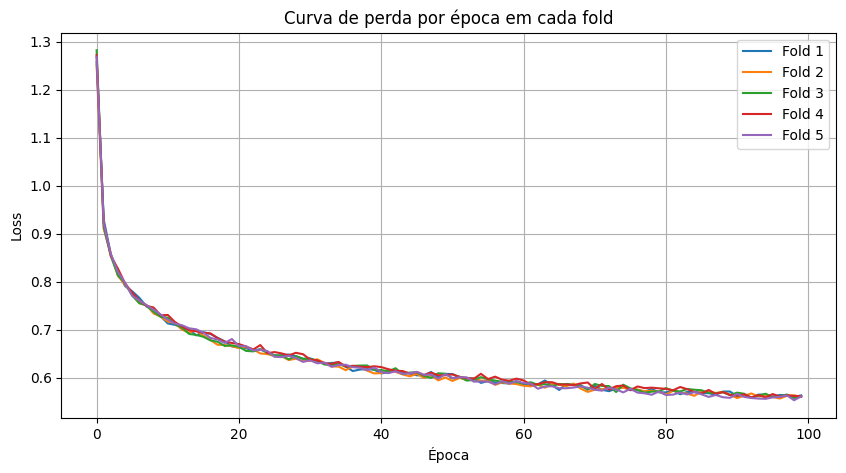

In [31]:
treinar_com_cross_validation(X, y, input_dim, output_dim, classe_nomes, num_epochs=100)


# Conclusão

Utilizando 8.000 imagens (10% do dataset original apenas, para fins didáticos e redução do tempo de execução do modelo), foi possível desenvolver um modelo que possui acurácia média 80,21% na classificação de imagens de satélite do bioma Cerrado em 8 tipos (Edificação, Área Cultivada, Floresta, Área Não Observada, Outros Usos, Pasto, Formação Savânica e Água)